In [1]:
import pickle

import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

from notebook_utils.constants import PROJ_ROOT, NEW_GENRES
from notebook_utils.feature_reduction import FeatureReducer
from notebook_utils.map_to_roget import make_clean_model_df, RogetMapper
from notebook_utils.predictions import Predictor
from notebook_utils.roget_themes import get_themes_by_genre, get_rosect_freq, get_wn_freq, \
    plot_theme_freq_diff, plot_avg_freq_diff_by_genre
from notebook_utils.utils import display_df, process_and_scale, create_cmap

%load_ext autoreload
%autoreload 2

tqdm.pandas()

fr = FeatureReducer(general=True)
p = Predictor(loader=fr.loader)
rm = RogetMapper(p)

c:\python37\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Show Loaded Data

In [2]:
fr.loader.show_model_df("WordNet")

Book #,@Genre,be,exist,equal,...,bromo-seltzer,sheeting,unrepaired,tax-exempt,@Outcome
10368,Adventure_Stories,0.397547,0.416203,0.394758,...,0.0,0.0,0.0,0.0,FAILURE
12190,Adventure_Stories,0.368411,0.367752,0.364972,...,0.0,0.0,0.0,0.0,FAILURE
13290,Adventure_Stories,0.326959,0.328435,0.325655,...,0.0,0.0,0.0,0.0,FAILURE
15072,Adventure_Stories,0.230889,0.229944,0.228356,...,0.0,0.0,0.0,0.0,FAILURE
18399,Adventure_Stories,0.271940,0.271644,0.270453,...,0.0,0.0,0.0,0.0,FAILURE
...,...,...,...,...,...,...,...,...,...,...
27462,Short_Stories,0.120100,0.126688,0.119539,...,0.0,0.0,0.0,0.0,SUCCESSFUL
2777,Short_Stories,0.222829,0.224782,0.222002,...,0.0,0.0,0.0,0.0,SUCCESSFUL
29948,Short_Stories,0.004856,0.005163,0.004766,...,0.0,0.0,0.0,0.0,SUCCESSFUL
3815,Short_Stories,0.180926,0.183082,0.178713,...,1.0,1.0,0.0,0.0,SUCCESSFUL


# Train and Reduce Models

### WordNet

In [3]:
wordnet_acc, wordnet_weights = p.predict_success(fr.loader.wordnet_df_scaled, "WordNet", disp_weights=False)

Genre,Accuracy
Adventure_Stories,0.749474
Fiction,0.690000
Historical_Fiction,0.600000
Love_Stories,0.757368
Mystery,0.660000
Poetry,0.728421
Science_Fiction,0.500000
Short_Stories,0.740000
Average,0.678158


In [4]:
wn_exh, wn_rw = fr.reduce_features(wordnet_weights, "WordNet", og_acc=wordnet_acc)

Adventure_Stories exhausted at 9.0 deviations above the mean
Fiction exhausted at 7.0 deviations above the mean
Historical_Fiction exhausted at 7.75 deviations above the mean
Love_Stories exhausted at 7.5 deviations above the mean
Mystery exhausted at 7.0 deviations above the mean
Poetry exhausted at 9.75 deviations above the mean
Science_Fiction exhausted at 12.25 deviations above the mean
Short_Stories exhausted at 12.5 deviations above the mean



# Mapping to Roget Sections

## Mapping WordNet (Not Reduced)

In [5]:
wn_df = make_clean_model_df(fr.loader.wordnet_data)

In [6]:
wn_set = {genre: wn_df[wn_df["@Genre"] == genre] for genre in NEW_GENRES}

In [9]:
NumsAndOutcomes = {genre: wn_df[wn_df["@Genre"] == genre][["Book #", "@Genre", "@Outcome"]].reset_index(drop=True) for genre in NEW_GENRES}

In [10]:
wn_to_rocat_no_scale, wn_to_rocat_scaled = rm.concat_map_to_roget(wn_to_rocat, "WordNet", "Category", NumsAndOutcomes)

In [11]:
wn_rosect_no_scale, wn_rosect_scaled = rm.map_to_roget(wn_to_rocat_no_scale, "WordNet", NumsAndOutcomes, to_sections=True)

### Test and Reduce Success Prediction for WordNet to Roget Sections

In [12]:
full_wn_rosect_acc, full_wn_rosect_weights, wn_rosect_acc, wn_rosect_weights = rm.test_map_to_roget(wn_rosect_no_scale, wn_rosect_scaled,
                                                                                                 src_model="WordNet", map_to="Section")

Genre,Accuracy
Adventure_Stories,0.596316
Fiction,0.620000
Historical_Fiction,0.540000
Love_Stories,0.523158
Mystery,0.520000
Poetry,0.477895
Science_Fiction,0.490000
Short_Stories,0.670000
Average,0.554671


Genre,Accuracy
Adventure_Stories,0.596316
Fiction,0.660000
Historical_Fiction,0.560000
Love_Stories,0.533684
Mystery,0.560000
Poetry,0.520000
Science_Fiction,0.560000
Short_Stories,0.680000
Average,0.583750


In [13]:
wn_rosect_df = rm.scale_mapped(wn_rosect_no_scale)
wn_rosect_exh, wn_rosect_rw = fr.reduce_features(full_wn_rosect_weights, "WordNet to Roget Section", model_df=wn_rosect_df, og_acc=full_wn_rosect_acc)

Adventure_Stories exhausted at 1.0 deviations above the mean
Fiction exhausted at 1.25 deviations above the mean
Historical_Fiction exhausted at 1.25 deviations above the mean
Love_Stories exhausted at 1.0 deviations above the mean
Mystery exhausted at 1.25 deviations above the mean
Poetry exhausted at 1.25 deviations above the mean
Science_Fiction exhausted at 0.5 deviations above the mean
Short_Stories exhausted at 0.75 deviations above the mean



Genre,Deviations,Accuracy,Num Features
Adventure_Stories,0.25000,0.606316,12.000
Fiction,1.00000,0.640000,5.000
Historical_Fiction,1.00000,0.560000,6.000
Love_Stories,0.50000,0.583684,7.000
Mystery,1.00000,0.570000,6.000
Poetry,0.50000,0.551579,11.000
Science_Fiction,0.00000,0.510000,11.000
Short_Stories,0.50000,0.680000,11.000
Average,0.59375,0.587697,8.625


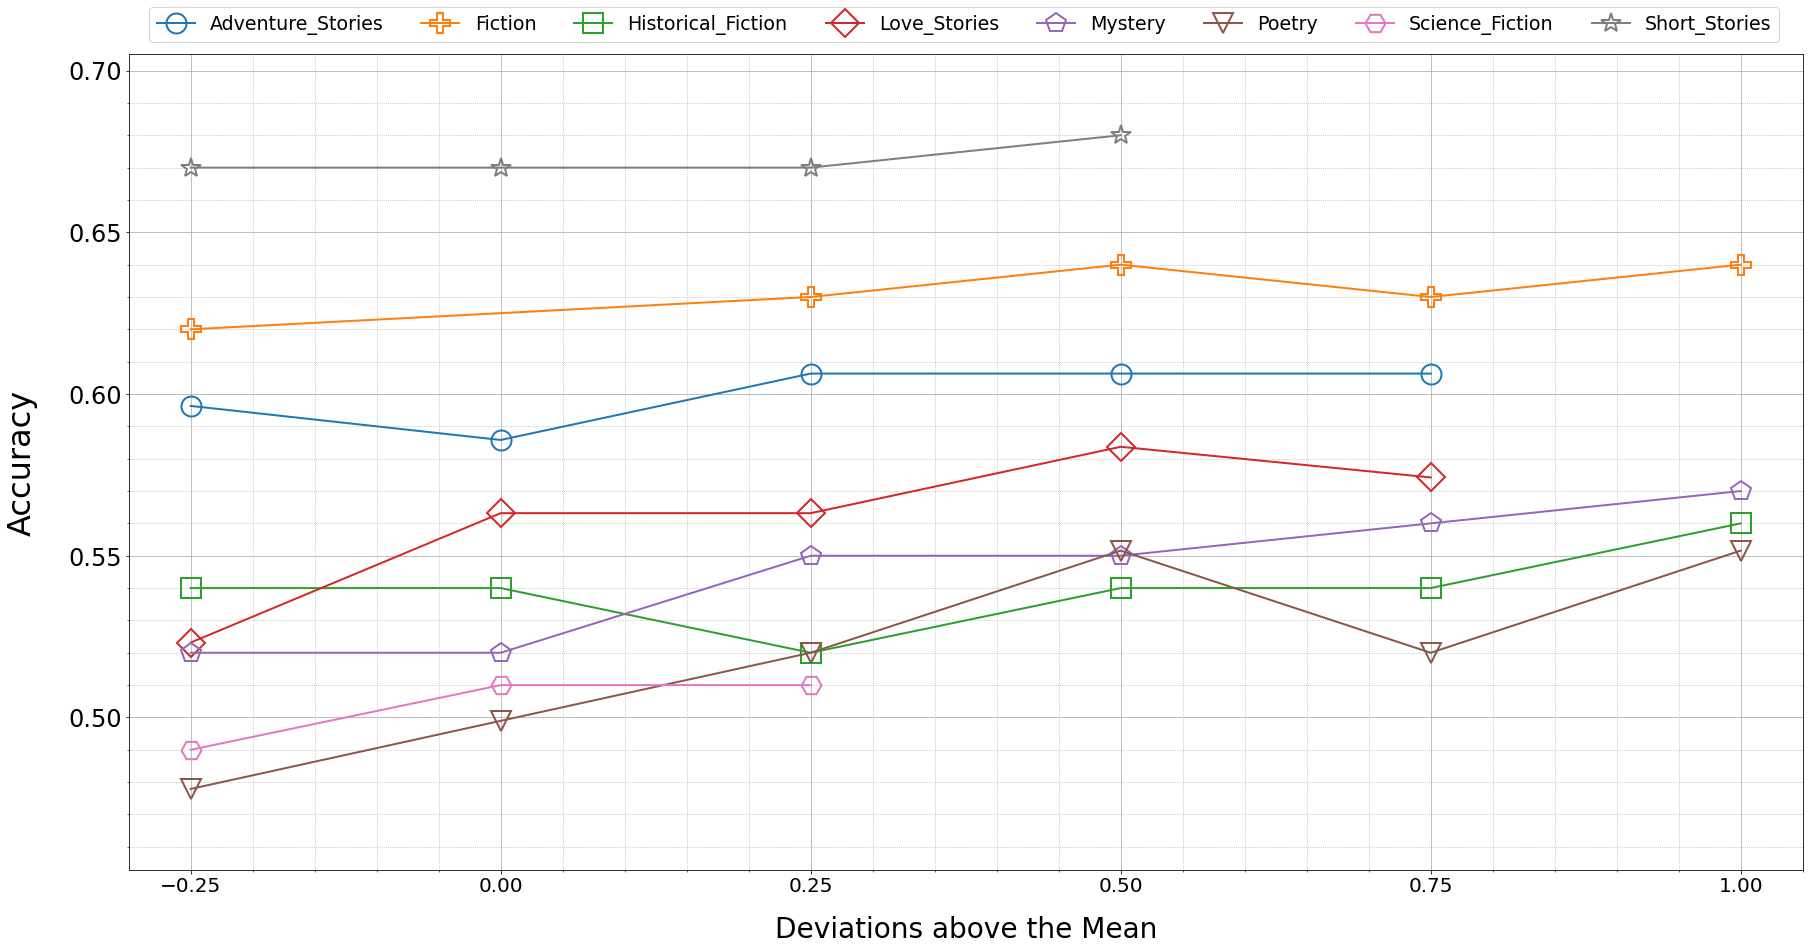

In [14]:
wn_rosect_reduced_acc = fr.plot_exhausted(wn_rosect_exh, markersize=20)

## Mapping WordNet (Reduced)

In [15]:
wnrf_set = {genre: wn_df[wn_df["@Genre"] == genre][["Book #", "@Genre"] + [w for w in wn_rw[genre]["Feature"]] + ["@Outcome"]] for genre in NEW_GENRES}

In [16]:
# wnrf_to_rocat_no_scale, wnrf_to_rocat_scaled = rm.map_to_roget(wnrf_set, "WordNet", NumsAndOutcomes, to_categories=True)

In [17]:
# wnrf_rosect_no_scale, wnrf_rosect_scaled = rm.map_to_roget(wnrf_to_rocat_no_scale, "WordNet", NumsAndOutcomes, to_sections=True)
wnrf_rosect_no_scale, wnrf_rosect_scaled = rm.map_to_roget(wnrf_set, "WordNet", NumsAndOutcomes, to_sections=True, push=True)

### Test and Reduce Success Prediction for WordNet to Roget Sections

In [18]:
full_wnrf_rosect_acc, full_wnrf_rosect_weights, wnrf_rosect_acc, wnrf_rosect_weights = rm.test_map_to_roget(wnrf_rosect_no_scale, wnrf_rosect_scaled,
                                                                                                         src_model="WordNet", map_to="Section")

Genre,Accuracy
Adventure_Stories,0.720000
Fiction,0.440000
Historical_Fiction,0.630000
Love_Stories,0.575263
Mystery,0.680000
Poetry,0.675263
Science_Fiction,0.430000
Short_Stories,0.660000
Average,0.601316


Genre,Accuracy
Adventure_Stories,0.834737
Fiction,0.770000
Historical_Fiction,0.700000
Love_Stories,0.757368
Mystery,0.720000
Poetry,0.695789
Science_Fiction,0.730000
Short_Stories,0.700000
Average,0.738487


In [19]:
wnrf_rosect_df = rm.scale_mapped(wnrf_rosect_no_scale)
wnrf_rosect_exh, wnrf_rosect_rw = fr.reduce_features(full_wnrf_rosect_weights, "WordNet to Roget Section", model_df=wnrf_rosect_df, og_acc=full_wnrf_rosect_acc)

Adventure_Stories exhausted at 1.0 deviations above the mean
Fiction exhausted at 2.5 deviations above the mean
Historical_Fiction exhausted at 1.5 deviations above the mean
Love_Stories exhausted at 1.0 deviations above the mean
Mystery exhausted at 1.25 deviations above the mean
Poetry exhausted at 1.5 deviations above the mean
Science_Fiction exhausted at 0.75 deviations above the mean
Short_Stories exhausted at 1.25 deviations above the mean



Genre,Deviations,Accuracy,Num Features
Adventure_Stories,-0.250,0.720000,23.000
Fiction,-0.250,0.440000,23.000
Historical_Fiction,1.000,0.650000,12.000
Love_Stories,0.500,0.615789,9.000
Mystery,-0.250,0.680000,23.000
Poetry,0.500,0.695789,11.000
Science_Fiction,0.000,0.440000,9.000
Short_Stories,-0.250,0.660000,23.000
Average,0.125,0.612697,16.625


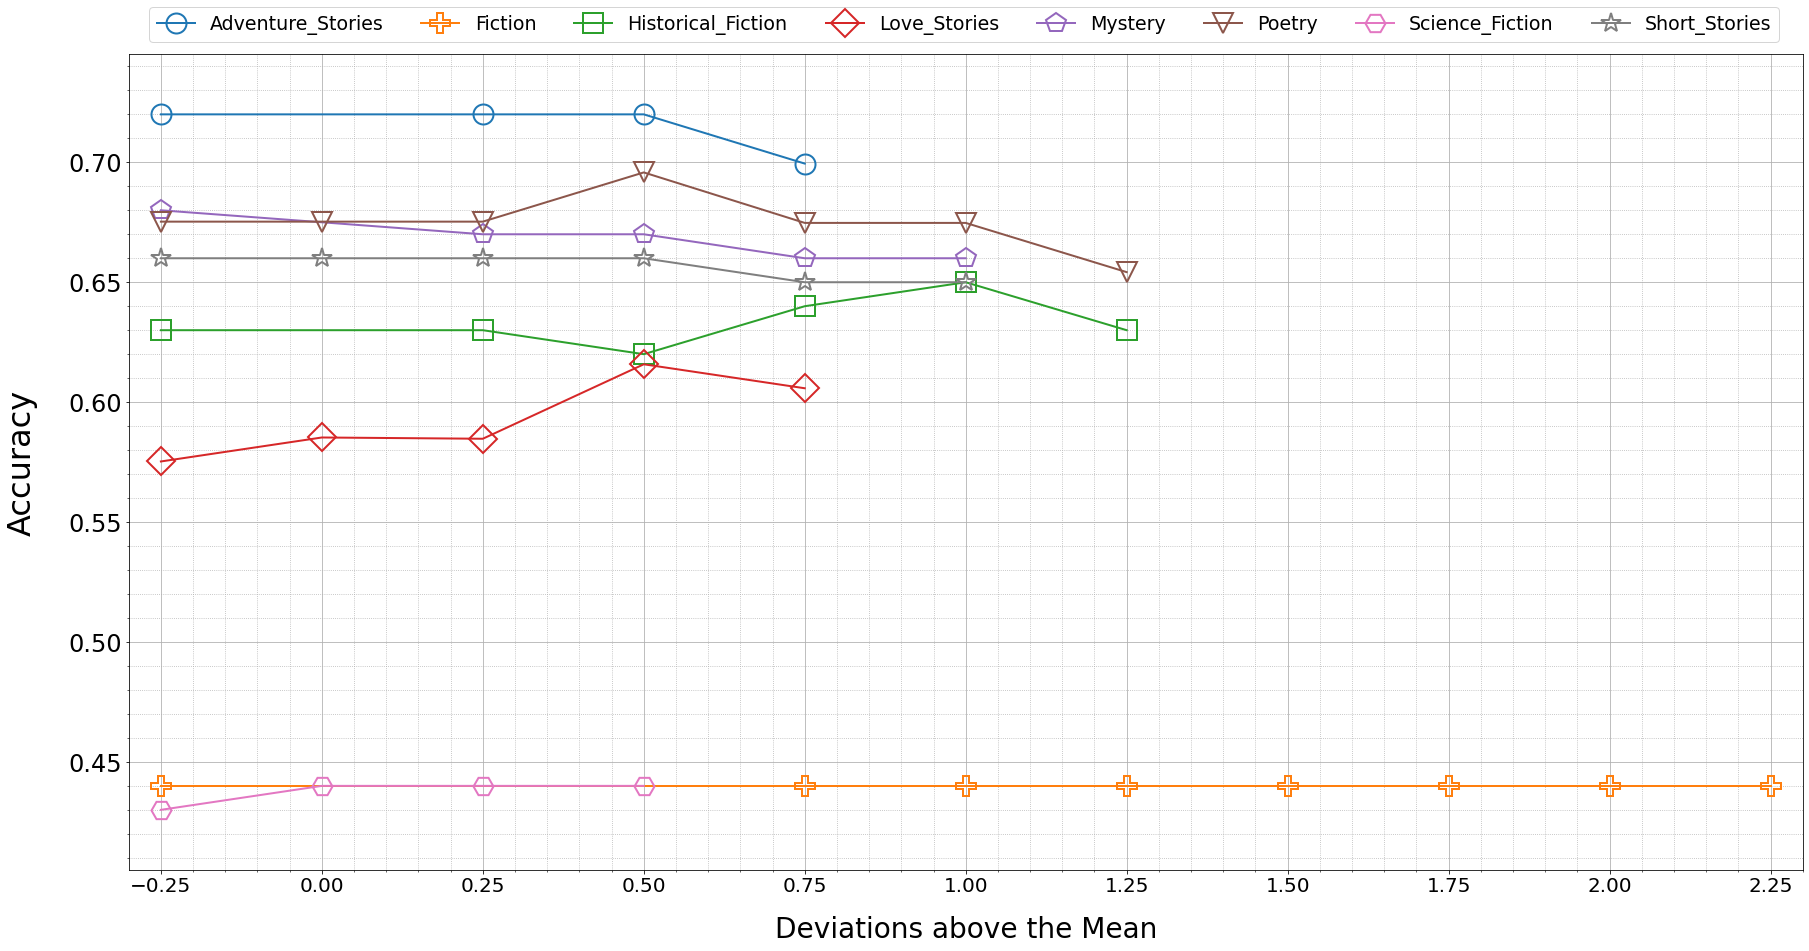

In [20]:
wnrf_rosect_reduced_acc = fr.plot_exhausted(wnrf_rosect_exh, markersize=20)

# Explore Themes

## WordNet to Roget (Not Reduced)

In [21]:
wn_rosect_set = {genre: wn_rosect_df[wn_rosect_df["@Genre"] == genre][["Book #", "@Genre"] + [w for w in full_wn_rosect_weights[genre]["Feature"]] + ["@Outcome"]] for genre in NEW_GENRES}

In [22]:
wn_rosect_themes_by_genre_df, wn_rosect_tbg_themes = get_themes_by_genre(wn_rosect_set, full_wn_rosect_weights)

In [23]:
wn_rosect_wvs_colors = create_cmap(plt.cm.nipy_spectral, wn_rosect_tbg_themes)

In [24]:
wn_rosect_wvs = get_rosect_freq(wn_rosect_set, wn_rosect_tbg_themes, wn_rosect_rw, name="wn_rosect")

## WordNet to Roget (Reduced)

In [25]:
wnrf_rosect_set = {genre: wnrf_rosect_df[wnrf_rosect_df["@Genre"] == genre][["Book #", "@Genre"] + [w for w in wnrf_rosect_rw[genre]["Feature"]] + ["@Outcome"]] for genre in NEW_GENRES}

In [26]:
wnrf_themes_by_genre_df, wnrf_tbg_themes = get_themes_by_genre(wnrf_rosect_set, wnrf_rosect_rw)

In [27]:
wnrf_rosect_wvs = get_rosect_freq(wnrf_rosect_set, wnrf_tbg_themes, wnrf_rosect_rw, name="wnrf_rosect")

## Get WordNet Words from Roget Themes

In [28]:
wnrf_set_scaled = {}
for genre in tqdm(NEW_GENRES):
    wnrf_set_scaled[genre], _ = process_and_scale(wnrf_set[genre])

In [29]:
wnrf_wvs = get_wn_freq(wnrf_set_scaled, wn_rw, name="wnrf")

In [30]:
wn_word_freqs = {}
for genre in NEW_GENRES:
    top = wnrf_wvs[genre].sort_values(by=["Frequency Difference"], ascending=False)[["Word", "Frequency Difference"]].head(10)
    bottom = wnrf_wvs[genre].sort_values(by=["Frequency Difference"])[["Word", "Frequency Difference"]].head(10)
    wn_word_freqs[genre] = pd.concat([top, bottom]).sort_values(by=["Frequency Difference"], ascending=False)
    display_df(wn_word_freqs[genre], f"<b>{genre}</b>")

Word,Frequency Difference
covert,0.234681
bitterness,0.210638
justification,0.192766
most,0.191232
absolve,0.170957
affluence,0.170213
spell,0.161864
curse,0.158501
picturesque,0.154043
desirable,0.151135


Word,Frequency Difference
excommunicate,0.210000
monster,0.200000
left_field,0.168000
finally,0.145455
maliciously,0.140000
left,0.138857
compact,0.137500
excusable,0.130000
twenty-four,0.130000
sallow,0.130000


Word,Frequency Difference
familiarly,0.200000
certain,0.159524
strongly,0.153333
parlance,0.140000
muscular,0.140000
meddling,0.140000
miserably,0.140000
outspread,0.140000
closeness,0.140000
mesomorphic,0.140000


Word,Frequency Difference
bedroom,0.211276
avert,0.205714
origin,0.199694
leftover,0.193644
countenance,0.186655
respectable,0.184184
abstractedness,0.184082
aspect,0.175973
rigorous,0.175918
till,0.167775


Word,Frequency Difference
alternative,0.180000
harmless,0.180000
summarize,0.160000
consecutive,0.160000
toast,0.158000
refuse,0.156250
engrave,0.153333
genius,0.151111
probe,0.144211
celebrity,0.140000


Word,Frequency Difference
difficult,0.195698
scour,0.173035
politic,0.168259
task,0.163265
invent,0.162831
legislative_act,0.161528
dispense,0.161528
second,0.159040
worst,0.154943
govern,0.149913


Word,Frequency Difference
agile,0.175000
wrench,0.165000
swoop,0.153333
cipher,0.140000
knock,0.135000
wide-eyed,0.124000
be_active,0.109333
motivate,0.109333
move,0.109052
disappear,0.108571


Word,Frequency Difference
hollow,0.190000
baby-sit,0.185263
sit_down,0.185263
sit,0.185263
slam_dance,0.180000
worldly_concern,0.176000
cover,0.174444
overlay,0.174000
note,0.171143
earth,0.171111


In [31]:
wnrf_to_rosect_dict = rm.map_to_roget(wnrf_set, "WordNet", NumsAndOutcomes, to_sections=True, concat=False, push=True)

In [32]:
wnrf_to_rosect_details = {}
for genre in NEW_GENRES:
    genre_details = []
    for word in wn_word_freqs[genre]["Word"]:
        for theme, info in wnrf_to_rosect_dict[genre].items():
            if word in info.columns:
                freq_diff = wn_word_freqs[genre].loc[wn_word_freqs[genre]["Word"] == word, "Frequency Difference"].values[0]
                genre_details.append({"Theme": theme, "Word": word, "Frequency Difference": freq_diff})
    
    wnrf_to_rosect_details[genre] = pd.DataFrame(genre_details)

In [33]:
for genre in NEW_GENRES:
    display_df(wnrf_to_rosect_details[genre].sort_values(by=["Theme", "Frequency Difference"]), f"<b>{genre}</b>")

Theme,Word,Frequency Difference
Communication of Ideas,picturesque,0.154043
Communication of Ideas,spell,0.161864
Communication of Ideas,justification,0.192766
Communication of Ideas,covert,0.234681
Individual Volition,plenty,-0.159043
Individual Volition,desirable,0.151135
Individual Volition,curse,0.158501
Individual Volition,spell,0.161864
Individual Volition,affluence,0.170213
Individual Volition,covert,0.234681


Theme,Word,Frequency Difference
Affections Generally,impetuous,-0.170000
Affections Generally,eager,-0.135000
Change,impetuous,-0.170000
Change,finally,0.145455
Communication of Ideas,compact,0.137500
Dimensions,buttock,-0.146316
Dimensions,cheek,-0.140000
Dimensions,compact,0.137500
Dimensions,left,0.138857
Dimensions,monster,0.200000


Theme,Word,Frequency Difference
Affections Generally,tingle,-0.200000
Affections Generally,fascinate,-0.130000
Change,muscular,0.140000
Change,strongly,0.153333
Communication of Ideas,revoke,-0.128333
Communication of Ideas,parlance,0.140000
Communication of Ideas,closeness,0.140000
Communication of Ideas,certain,0.159524
Dimensions,outspread,0.140000
Dimensions,closeness,0.140000


Theme,Word,Frequency Difference
Change,origin,0.199694
Communication of Ideas,formal,-0.157551
Dimensions,clasp,-0.163353
Dimensions,countenance,0.186655
Existence,formal,-0.157551
Existence,aspect,0.175973
Form,aspect,0.175973
Formation of Ideas,nice,-0.205912
Formation of Ideas,rigorous,0.175918
Formation of Ideas,aspect,0.175973


Theme,Word,Frequency Difference
Affections Generally,startle,-0.160000
Change,alternative,0.180000
Change,harmless,0.180000
Communication of Ideas,engrave,0.153333
Communication of Ideas,refuse,0.156250
Communication of Ideas,summarize,0.160000
Dimensions,probe,0.144211
Form,probe,0.144211
Form,engrave,0.153333
Formation of Ideas,trip,-0.179667


Theme,Word,Frequency Difference
Affections Generally,thrill,-0.171904
Change,fitful,-0.145571
Communication of Ideas,blot,-0.133572
Communication of Ideas,invent,0.162831
Communication of Ideas,task,0.163265
Form,dimple,-0.135620
Formation of Ideas,blot,-0.133572
Formation of Ideas,invent,0.162831
Formation of Ideas,politic,0.168259
Individual Volition,fitful,-0.145571


Theme,Word,Frequency Difference
Affections Generally,move,0.109052
Change,knock,0.135000
Communication of Ideas,manual,-0.086667
Communication of Ideas,cipher,0.140000
Existence,unreal,-0.080000
Existence,disappear,0.108571
Existence,cipher,0.140000
Formation of Ideas,experimental,-0.093333
Formation of Ideas,surprisingly,-0.080000
Formation of Ideas,known,-0.080000


Theme,Word,Frequency Difference
Affections Generally,whet,-0.093333
Communication of Ideas,note,0.171143
Communication of Ideas,overlay,0.174000
Communication of Ideas,cover,0.174444
Communication of Ideas,hollow,0.190000
Dimensions,earth,0.171111
Dimensions,overlay,0.174000
Dimensions,cover,0.174444
Dimensions,hollow,0.190000
Existence,hollow,0.190000


# Plot Frequency Differences

## Theme Frequency Difference per Genre

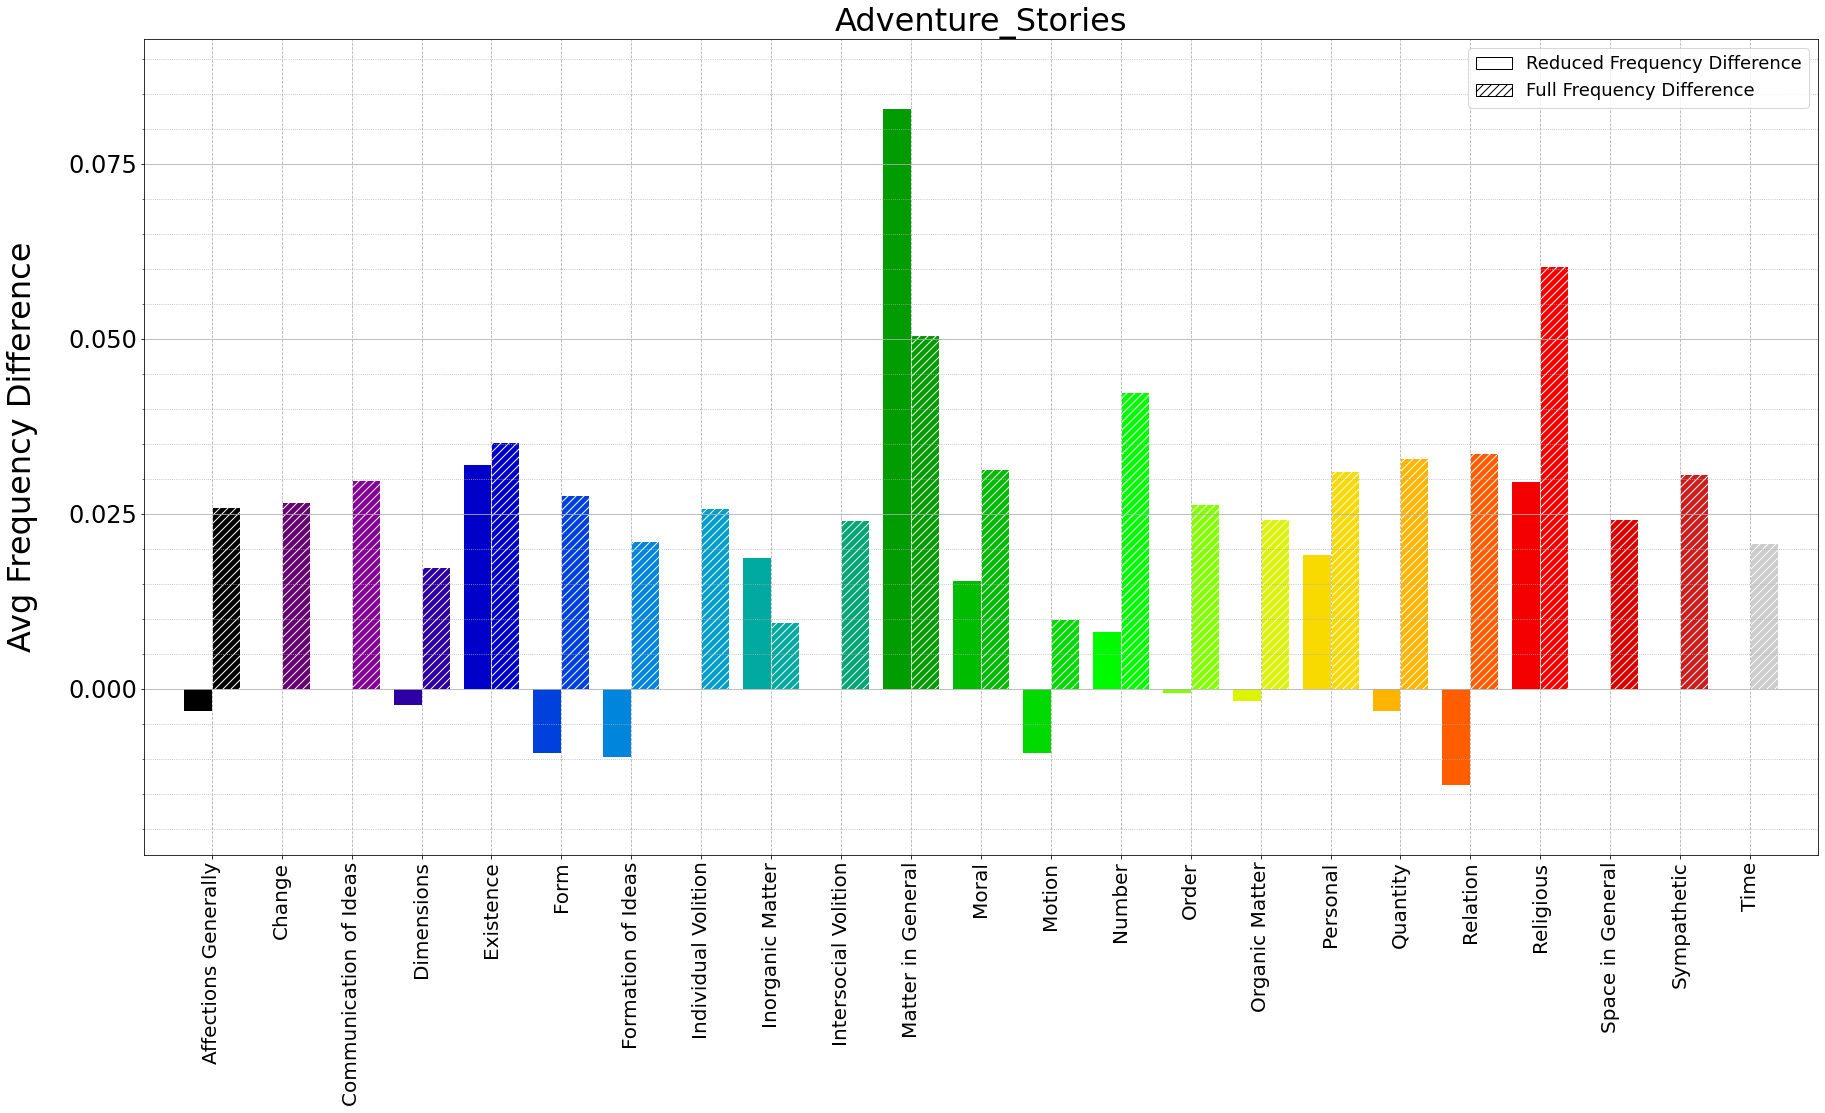

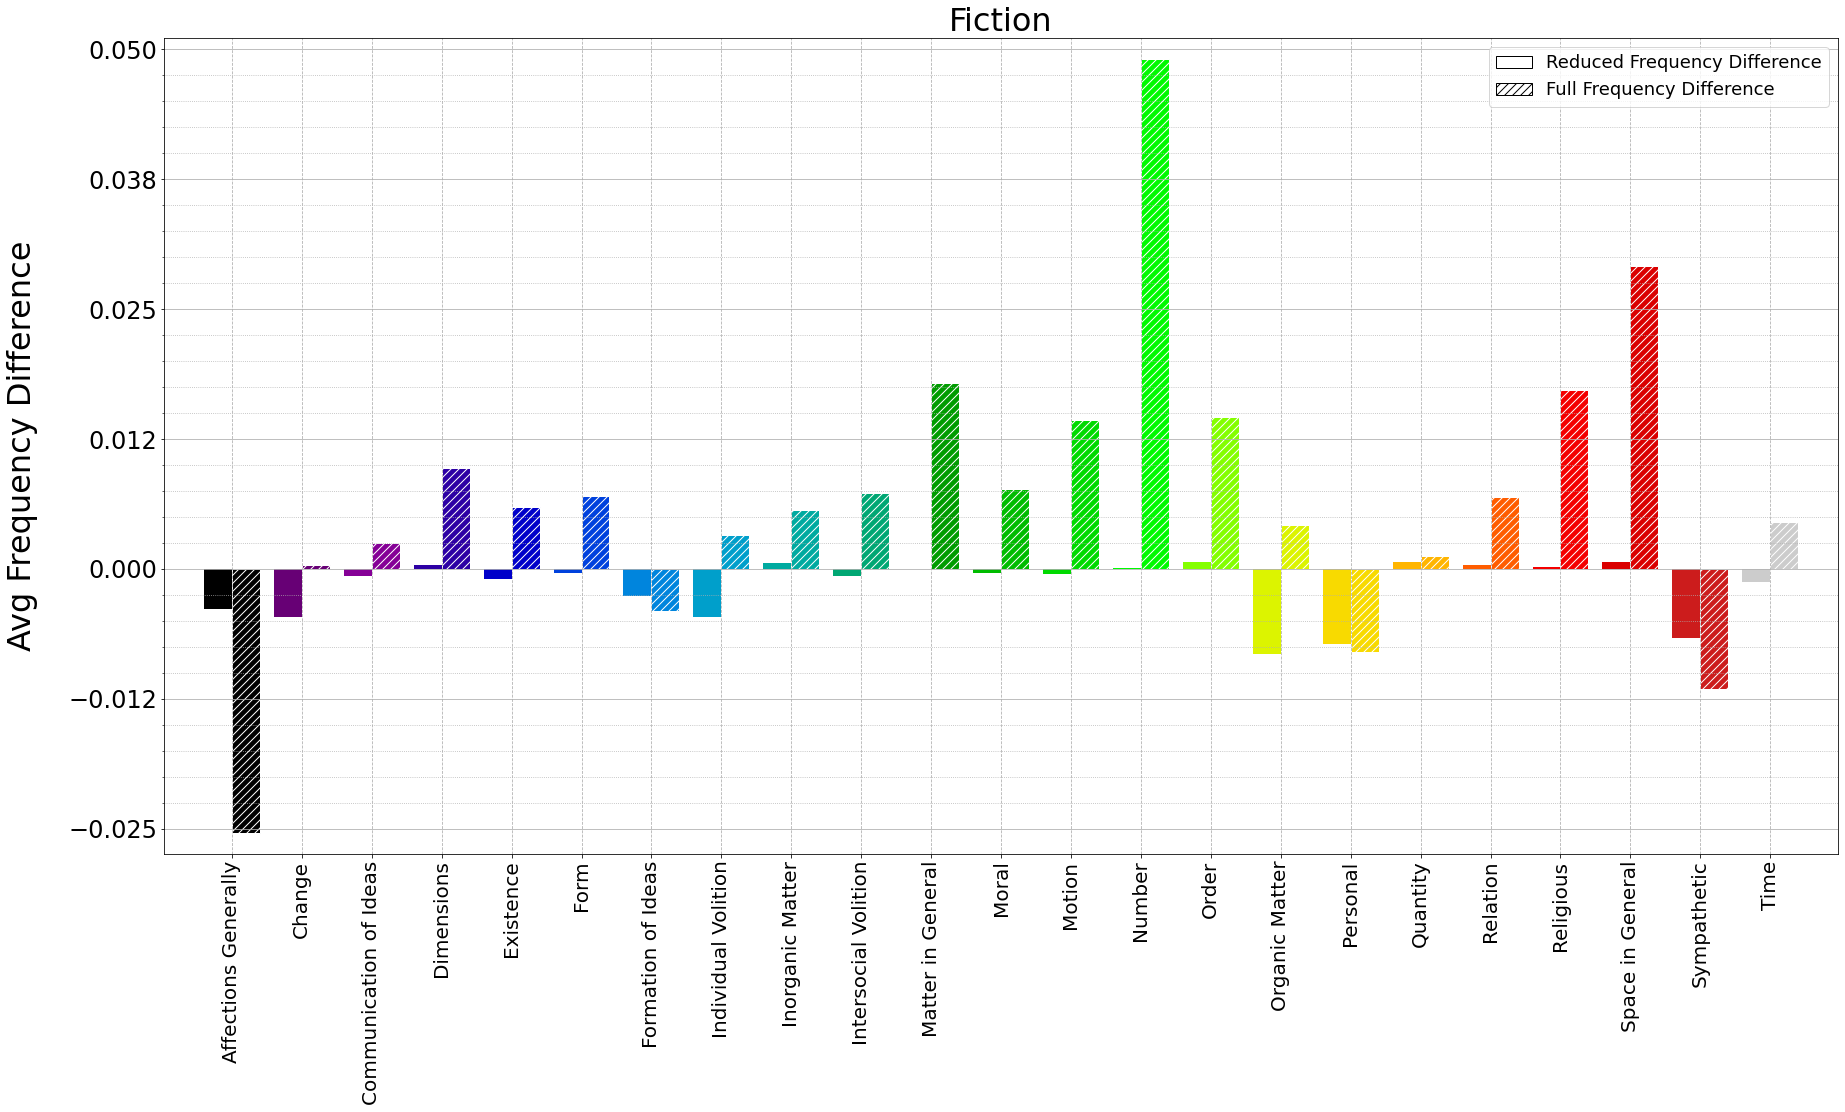

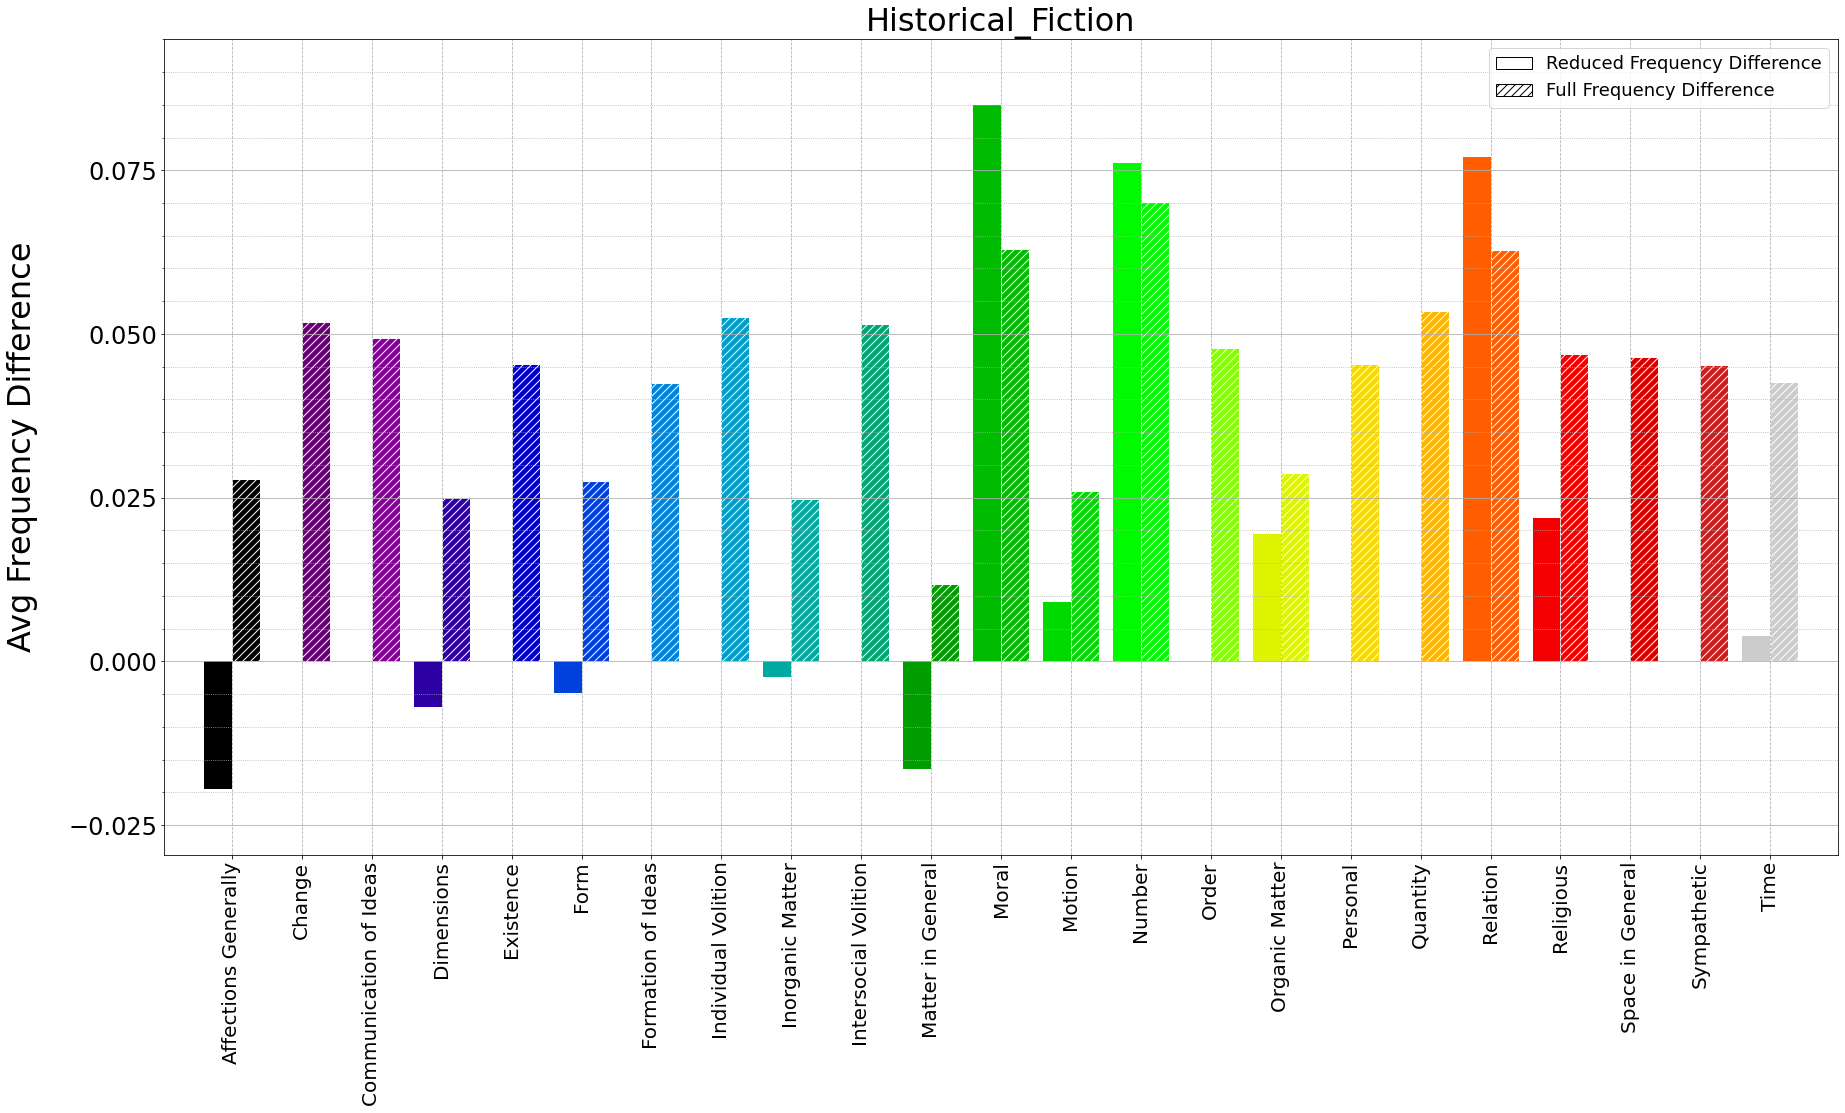

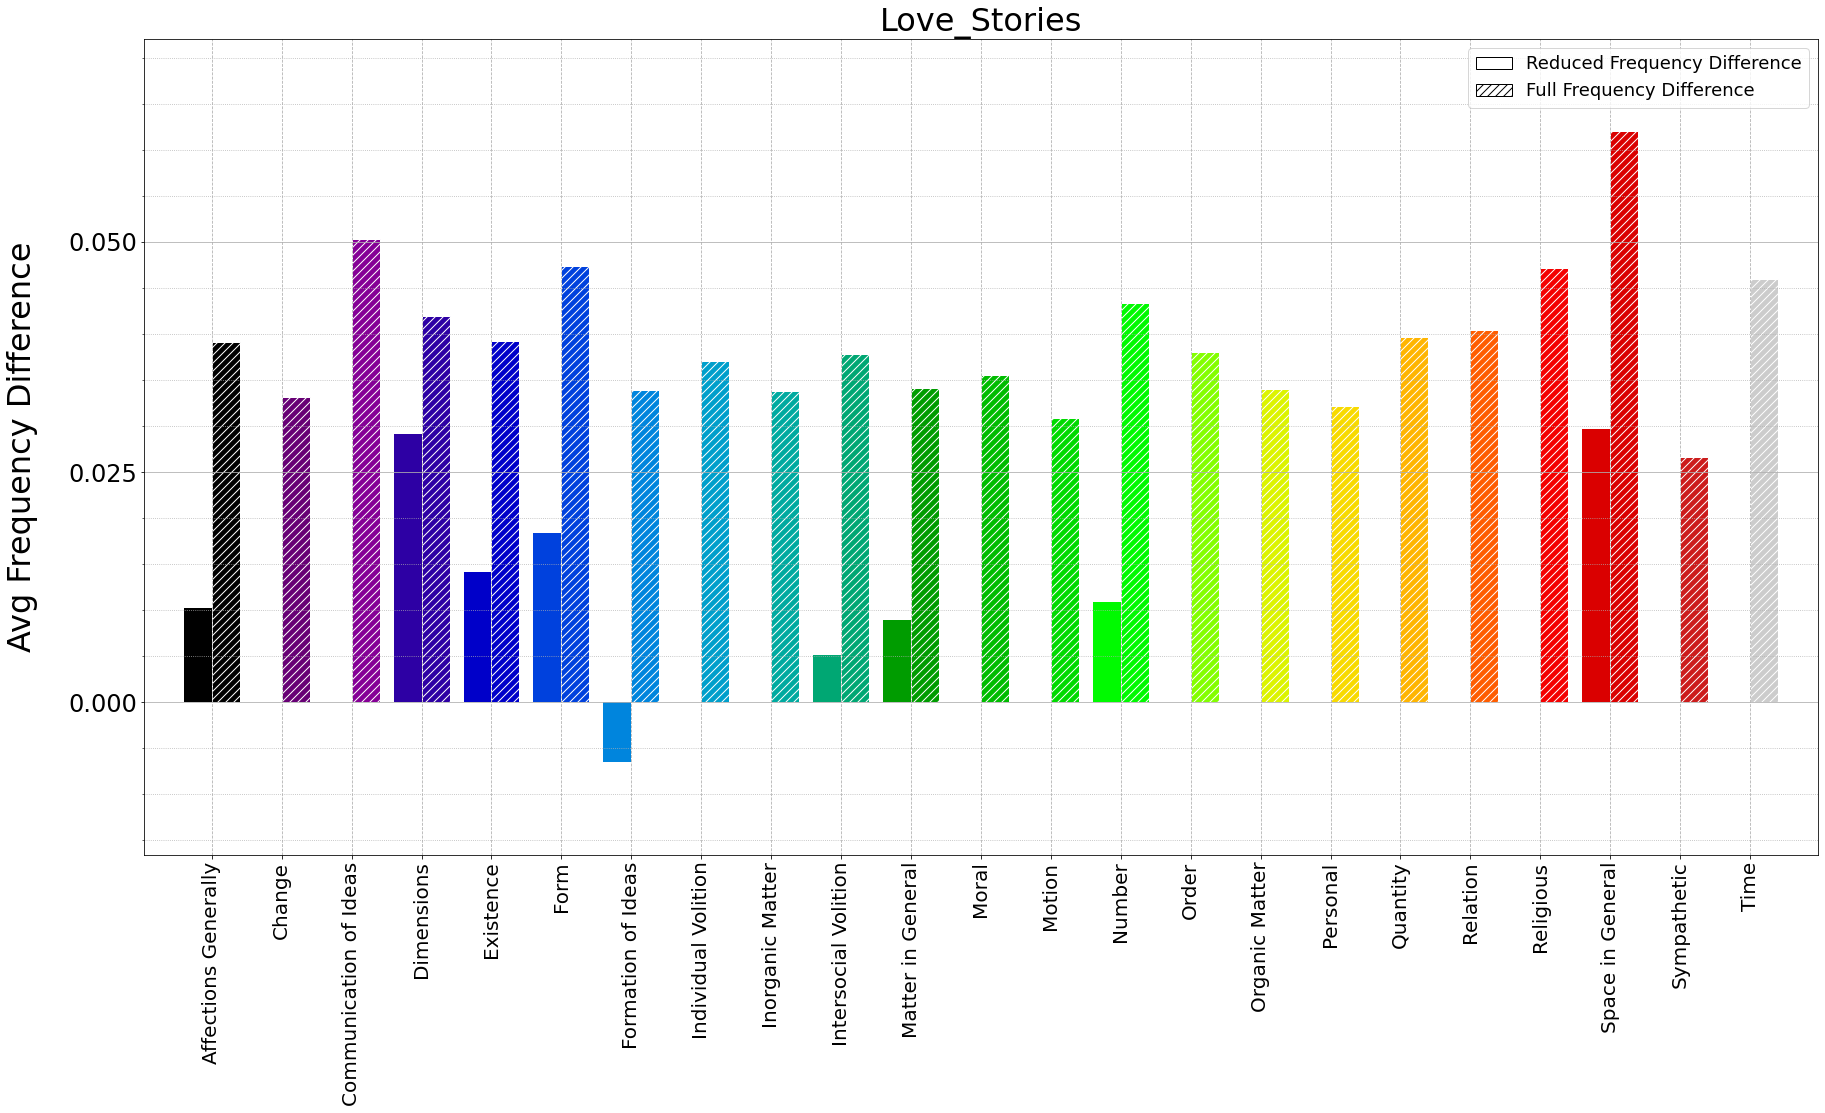

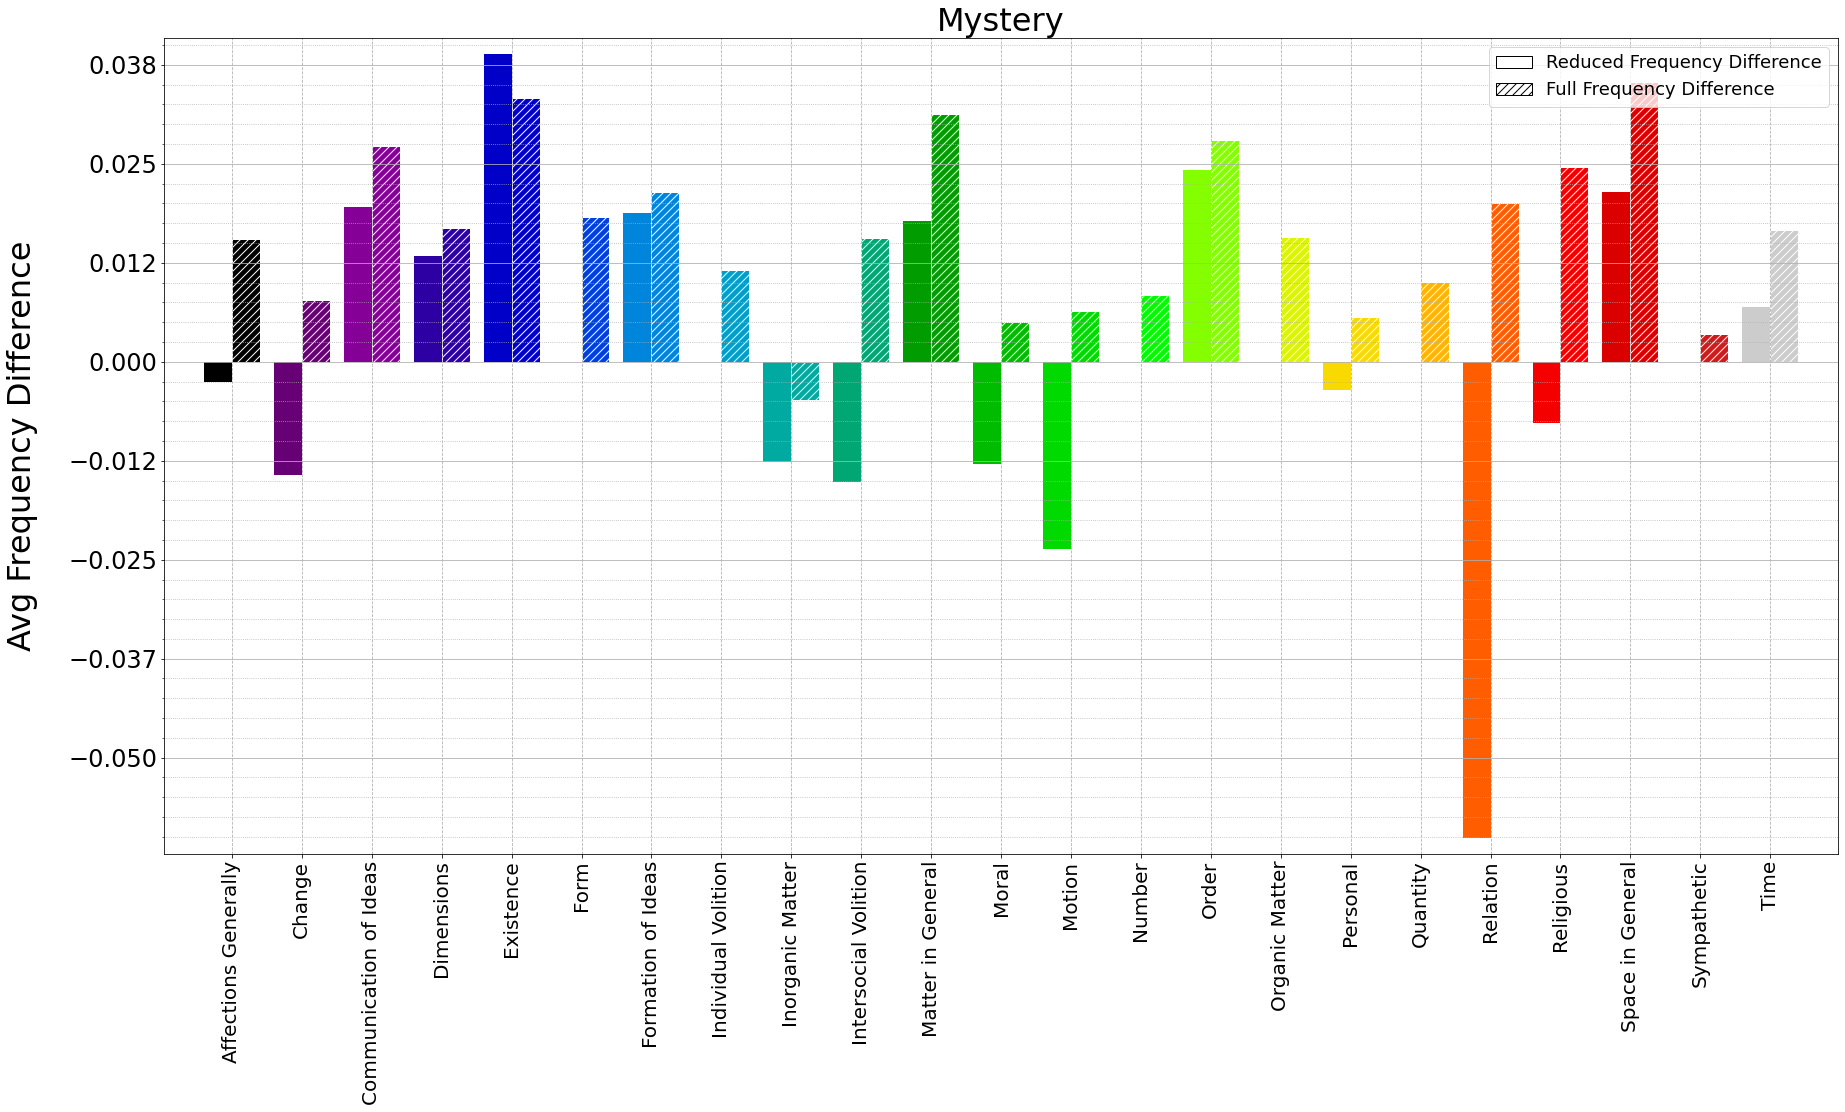

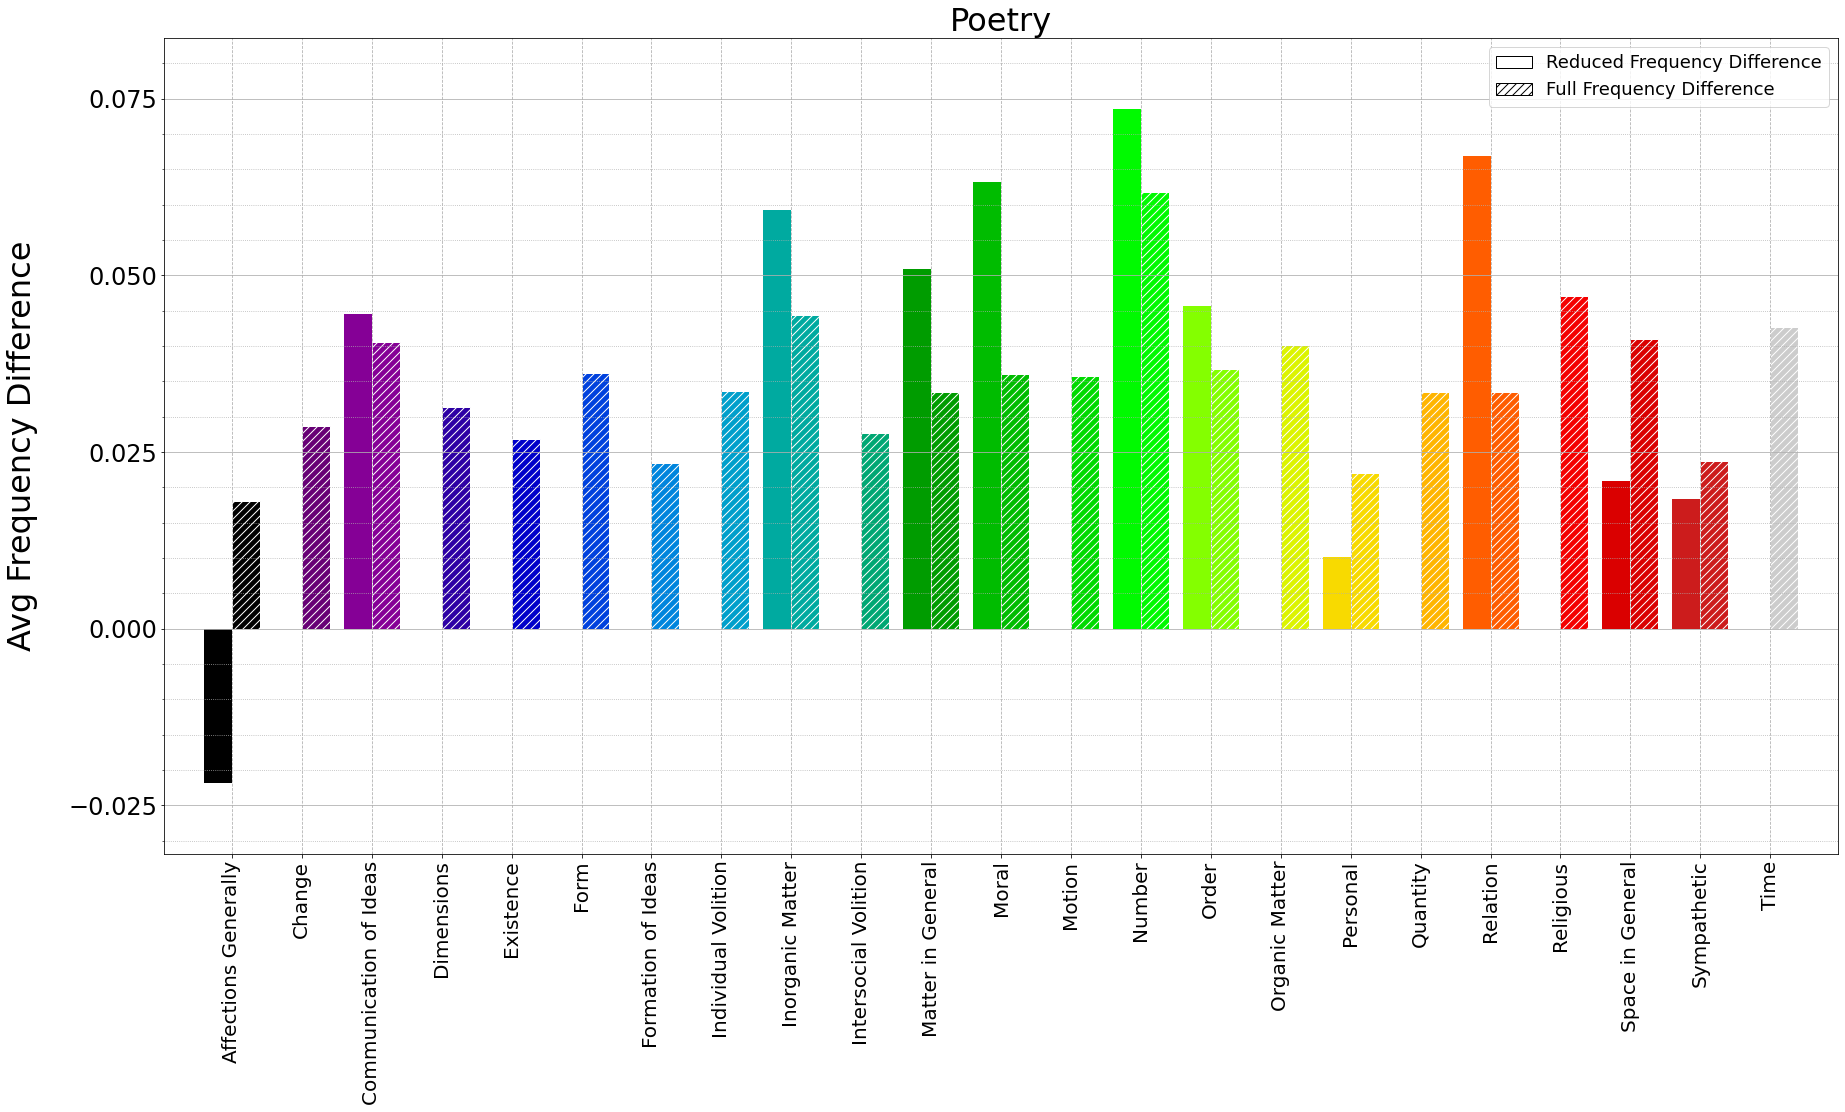

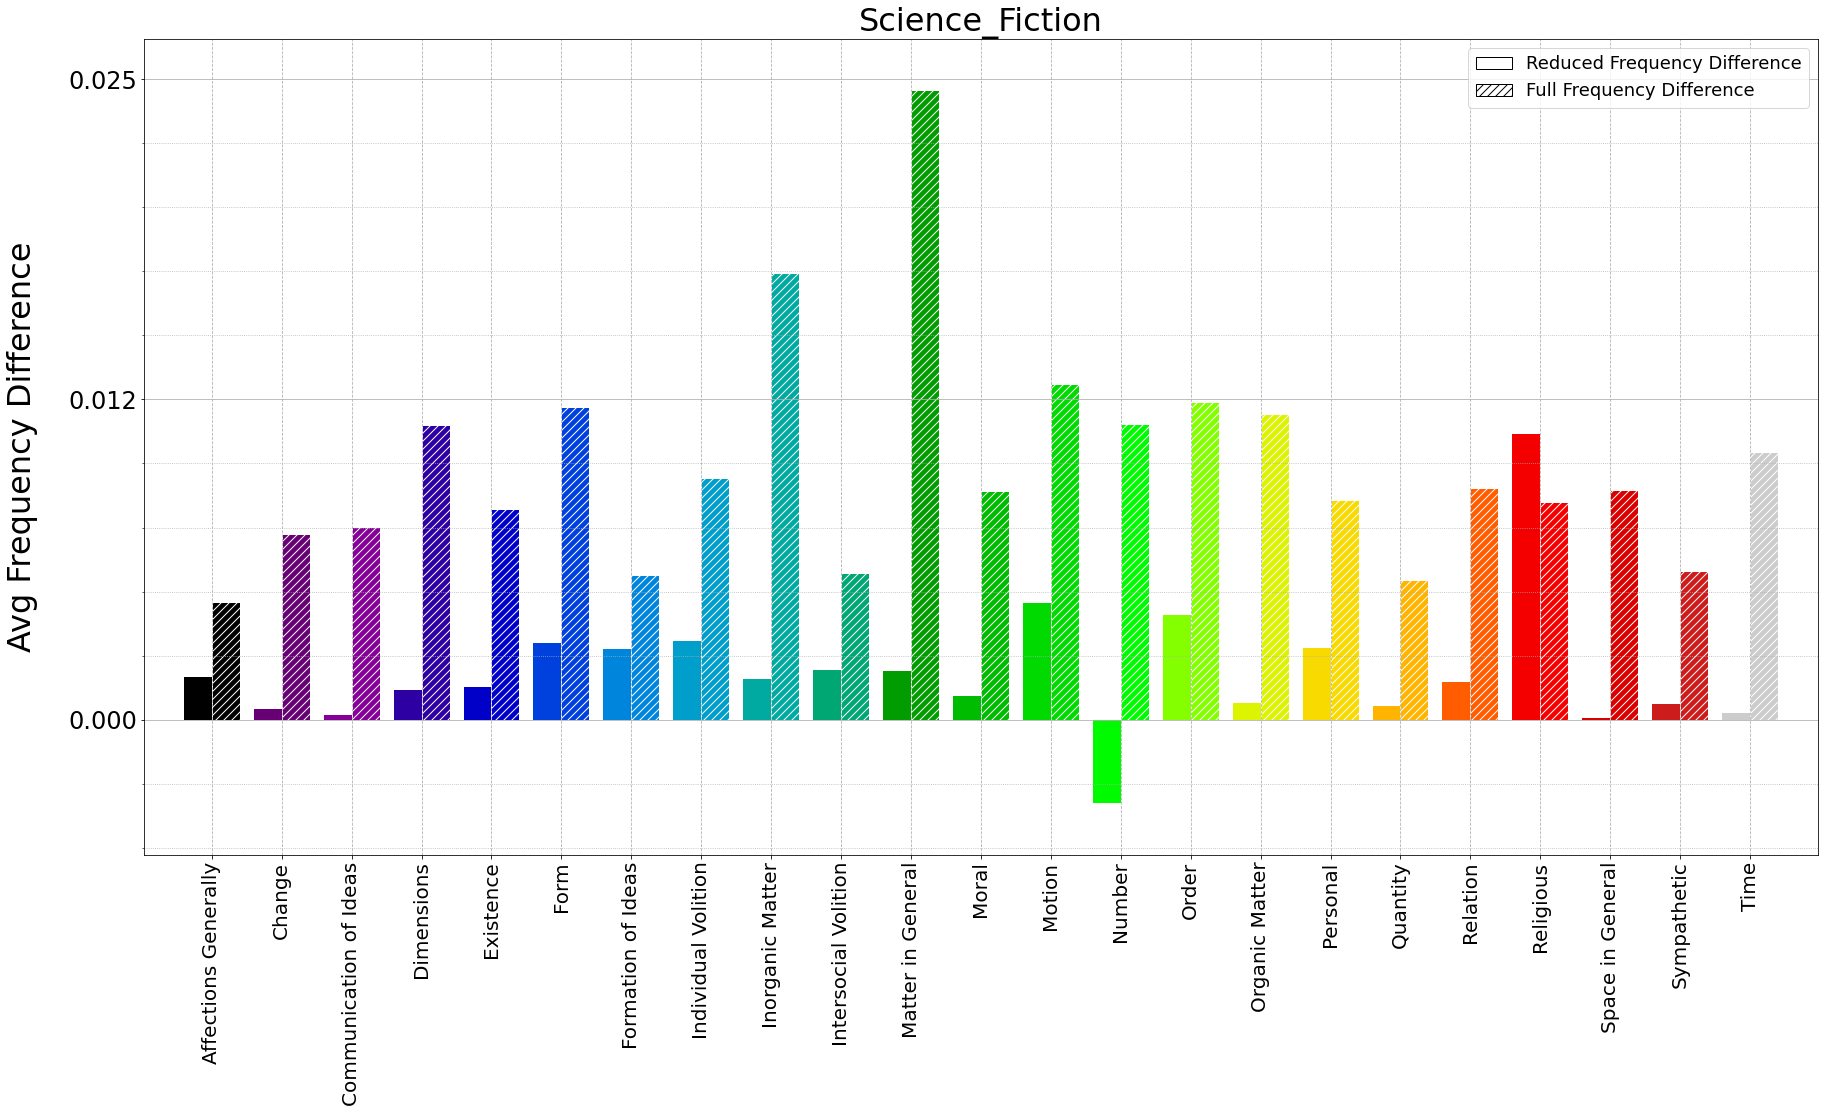

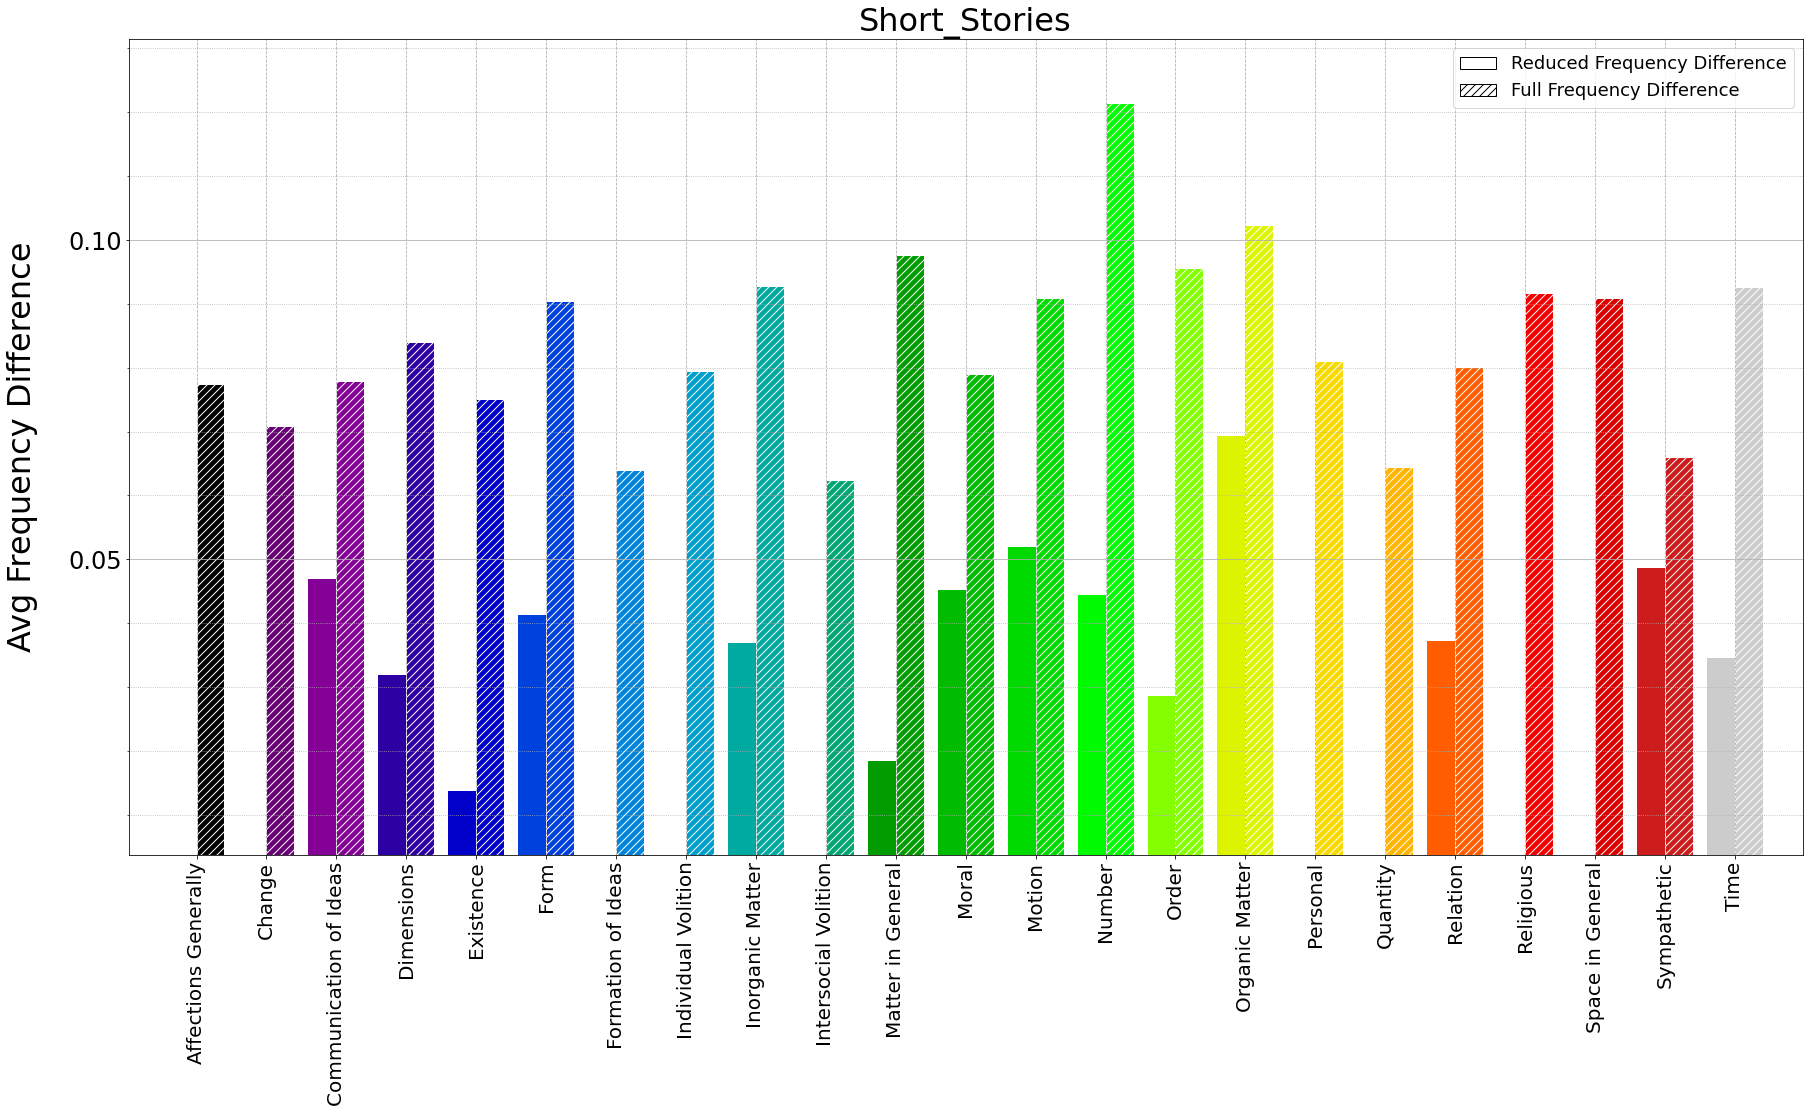

In [34]:
plot_theme_freq_diff(wnrf_rosect_wvs, wn_rosect_wvs_colors, other_wvs=wn_rosect_wvs)

## Average Theme Frequency Difference by Genre, Reduced vs. Non-Reduced

Genre,Average Frequency Difference (Reduced),Average Frequency Difference
Adventure_Stories,0.016145,0.028791
Fiction,0.002101,0.011203
Historical_Fiction,0.028530,0.043012
Love_Stories,0.014774,0.039293
Mystery,0.018467,0.016661
Poetry,0.043219,0.034716
Science_Fiction,0.002149,0.009946
Short_Stories,0.039219,0.083837
Average,0.020575,0.033432


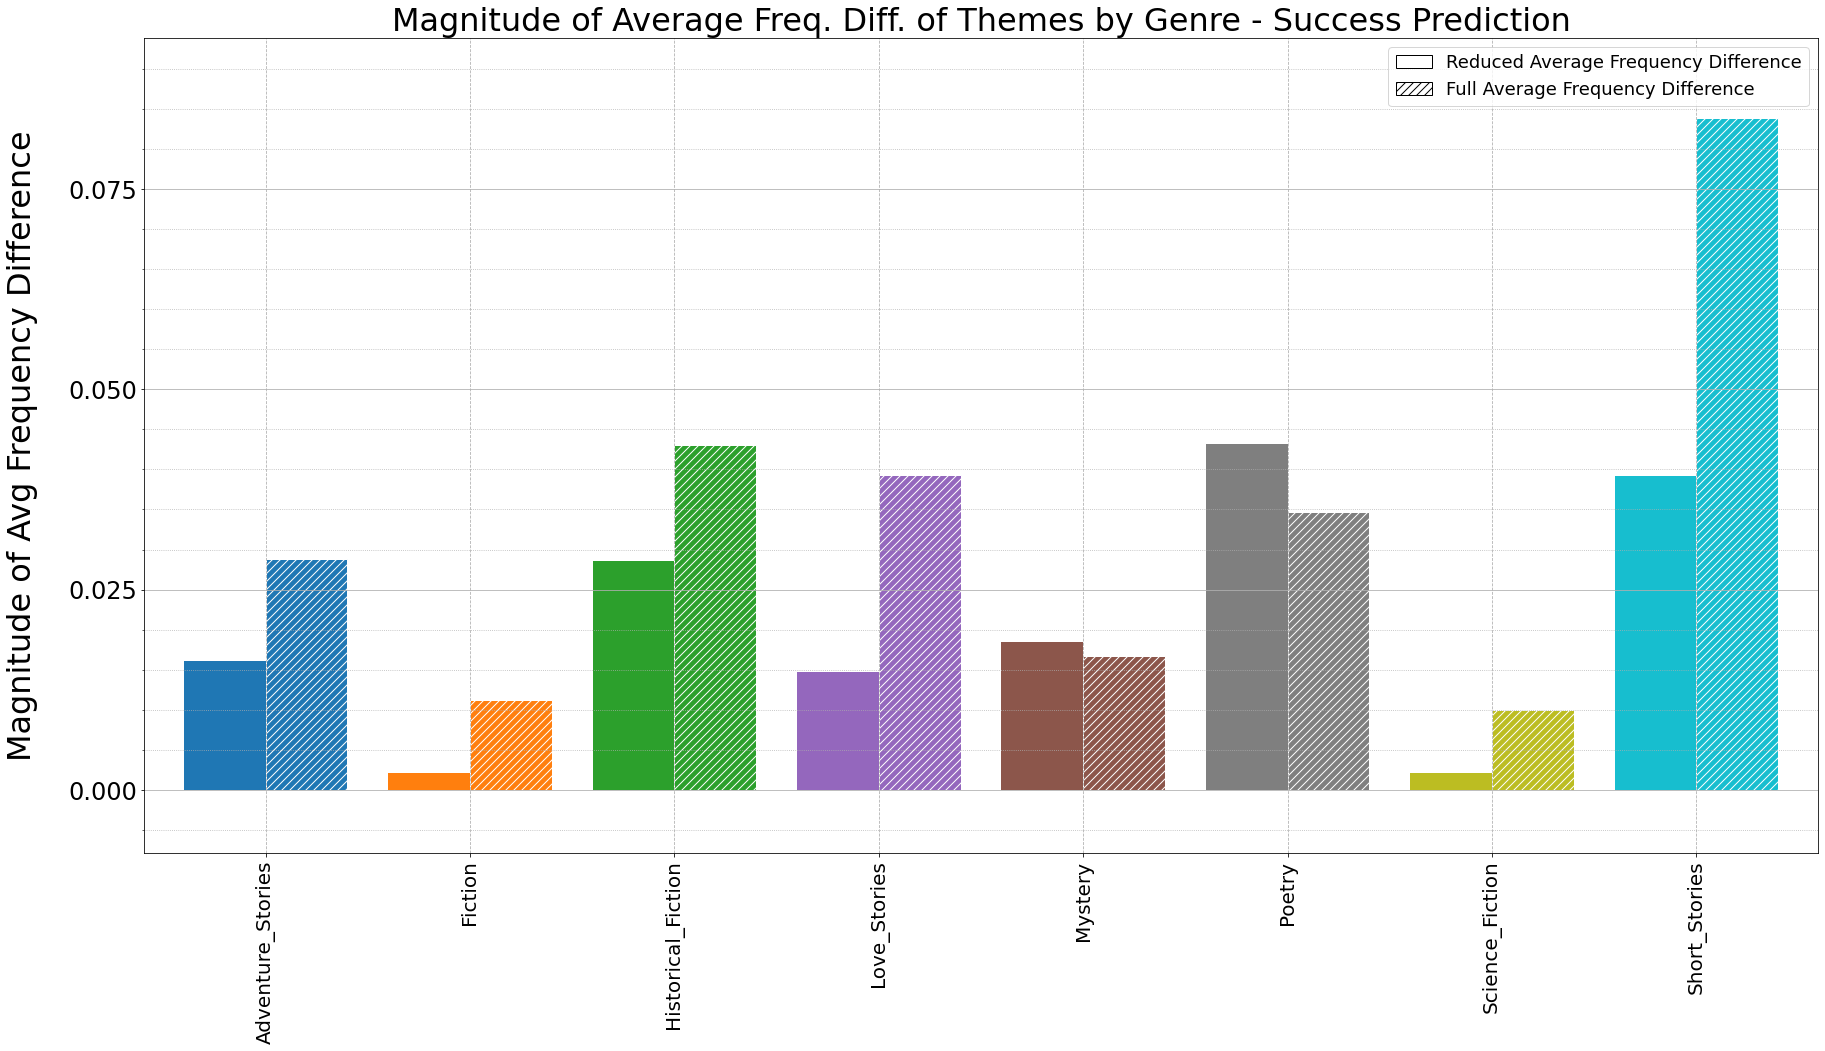

In [35]:
plot_avg_freq_diff_by_genre(wnrf_rosect_wvs, create_cmap(plt.cm.tab10, NEW_GENRES), other_wvs=wn_rosect_wvs,
                            title="Magnitude of Average Freq. Diff. of Themes by Genre - Success Prediction")